In [7]:
import numpy as np
import pandas as pd
import json
import random
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from typing import Dict, List, Tuple, Set
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

class EnhancedMatrixRecommender:
    def __init__(self, n_factors: int = 40):
        self.n_factors = n_factors
        self.user_encoder = LabelEncoder()
        self.genre_list = set()
        self.train_interactions = None
        self.test_interactions = None

    # load 1000 books and 10000 reviews
    def load_book_metadata(self, books_file: str) -> Dict[str, Dict]:
        books_data = {}
        try:
            with open(books_file, 'r', encoding='utf-8') as f:
                for i, line in enumerate(f):
                    if i >= 1000:  
                        break
                        
                    try:
                        book = json.loads(line.strip())
                        book_id = book['book_id']
                        
                        # Extract genres
                        genres = set()
                        for shelf in book.get('popular_shelves', []):
                            shelf_name = shelf['name'].lower()
                            # if not exist, create one
                            if shelf_name not in {'to-read', 'currently-reading', 'owned', 'default', 'favorites'}:
                                genres.add(shelf_name)
                                self.genre_list.add(shelf_name)
                        
                        # read data
                        try:
                            publication_year = int(book.get('publication_year')) if book.get('publication_year') else 0
                        except (ValueError, TypeError):
                            publication_year = 0

                        try:
                            average_rating = float(book.get('average_rating')) if book.get('average_rating') else 0.0
                        except (ValueError, TypeError):
                            average_rating = 0.0

                        try:
                            ratings_count = int(book.get('ratings_count')) if book.get('ratings_count') else 0
                        except (ValueError, TypeError):
                            ratings_count = 0
                        
                        books_data[book_id] = {
                            'title': book.get('title', ''),
                            'genres': genres,
                            'average_rating': average_rating,
                            'ratings_count': ratings_count,
                            'publication_year': publication_year,
                            'language': book.get('language_code', ''),
                            'authors': [author['author_id'] for author in book.get('authors', [])],
                            'publisher': book.get('publisher', '')
                        }
                        
                    except Exception as e:
                        print(f"Error processing book at line {i}: {str(e)}")
                        continue
                        
            print(f"Successfully loaded {len(books_data)} books")
            return books_data
            
        except Exception as e:
            print(f"Error loading book metadata: {str(e)}")
            return {}

    def load_review_data(self, reviews_file: str, books_data: Dict[str, Dict], n_samples: int = None) -> pd.DataFrame:
        """Load review data and filtering for available books only"""
        reviews = []
        skipped_count = 0
        total_processed = 0
        
        with open(reviews_file, 'rt', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if n_samples and total_processed >= n_samples:
                    break
                try:
                    review = json.loads(line.strip())
                    book_id = str(review['book_id'])
                    
                    if book_id in books_data:
                        try:
                            rating = float(review.get('rating', 0))
                            if rating > 3:
                                reviews.append({
                                    'user_id': review['user_id'],
                                    'book_id': book_id,
                                    'rating': rating
                                })
                                total_processed += 1
                            else:
                                skipped_count += 1
                        except (ValueError, TypeError):
                            skipped_count += 1
                    else:
                        skipped_count += 1
                        
                except Exception as e:
                    print(f"Error processing review at line {i}: {str(e)}")
                    skipped_count += 1
                    continue
        
        df = pd.DataFrame(reviews)
        print(f"Loaded {len(df)} valid reviews for {len(df['book_id'].unique())} unique books")
        print(f"Skipped {skipped_count} reviews due to missing data or invalid values")
        return df


    def create_feature_matrices(self, df: pd.DataFrame, books_data: Dict[str, Dict]):
        """Create feature matrices"""
        try:
            df = df.copy()
            df['user_id_encoded'] = self.user_encoder.fit_transform(df['user_id'].values)
            self.n_users = len(self.user_encoder.classes_)
            
            print(f"Creating matrices for {self.n_users} users...")
            
            matrices = {}
            print("Creating genre matrix...")
            matrices['genre'] = self._create_genre_matrix(df, books_data)
            
            print("Creating year matrix...")
            matrices['year'] = self._create_year_matrix(df, books_data)
            
            print("Creating publisher matrix...")
            matrices['publisher'] = self._create_publisher_matrix(df, books_data)
            
            print("Creating rating matrix...")
            matrices['rating'] = self._create_rating_matrix(df)
            
            return matrices
            
        except Exception as e:
            print(f"Error creating feature matrices: {str(e)}")
            raise

    def _create_genre_matrix(self, df: pd.DataFrame, books_data: Dict[str, Dict]) -> csr_matrix:
        """Create user-genre matrix"""
        genre_list = sorted(self.genre_list)
        genre_to_idx = {genre: idx for idx, genre in enumerate(genre_list)}
        
        
        # Sparse matrix
        rows, cols, data = [], [], []
        for _, row in df.iterrows():
            user_idx = row['user_id_encoded']
            book_genres = books_data[row['book_id']]['genres']
            rating = row['rating']
            
            for genre in book_genres:
                if genre in genre_to_idx:
                    rows.append(user_idx)
                    cols.append(genre_to_idx[genre])
                    data.append(rating)
        
        # (data, (rows, cols)) format
        return csr_matrix(
            (data, (rows, cols)),
            shape=(self.n_users, len(genre_list)),
            dtype=np.float64
        )

    def _create_year_matrix(self, df: pd.DataFrame, books_data: Dict[str, Dict]) -> csr_matrix:
        """Create user-decade matrix"""
        decades = sorted({books_data[book_id]['publication_year'] // 10 * 10 
                         for book_id in df['book_id'] 
                         if books_data[book_id]['publication_year'] > 0})
        
        if not decades:
            return csr_matrix((self.n_users, 0), dtype=np.float64)
        
        decade_to_idx = {decade: idx for idx, decade in enumerate(decades)}
        
        rows, cols, data = [], [], []
        for _, row in df.iterrows():
            year = books_data[row['book_id']]['publication_year']
            if year > 0:
                # lower bound of year
                decade = year // 10 * 10
                if decade in decade_to_idx:
                    rows.append(row['user_id_encoded'])
                    cols.append(decade_to_idx[decade])
                    data.append(row['rating'])
        
        return csr_matrix(
            (data, (rows, cols)),
            shape=(self.n_users, len(decades)),
            dtype=np.float64
        )

    def _create_publisher_matrix(self, df: pd.DataFrame, books_data: Dict[str, Dict]) -> csr_matrix:
        """Create user-publisher matrix"""
        publishers = sorted({books_data[book_id]['publisher'] 
                           for book_id in df['book_id'] 
                           if books_data[book_id]['publisher']})
        publisher_to_idx = {pub: idx for idx, pub in enumerate(publishers)}
        
        rows, cols, data = [], [], []
        for _, row in df.iterrows():
            publisher = books_data[row['book_id']]['publisher']
            if publisher and publisher in publisher_to_idx:
                rows.append(row['user_id_encoded'])
                cols.append(publisher_to_idx[publisher])
                data.append(row['rating'])
        
        n_publishers = len(publisher_to_idx)
        if n_publishers == 0:
            return csr_matrix((self.n_users, 0), dtype=np.float64)
            
        return csr_matrix(
            (data, (rows, cols)),
            shape=(self.n_users, n_publishers),
            dtype=np.float64
        )

    def _create_rating_matrix(self, df: pd.DataFrame) -> csr_matrix:
        """Create user-book rating"""
        book_ids = sorted(set(df['book_id']))
        book_to_idx = {book_id: idx for idx, book_id in enumerate(book_ids)}
        
        rows = df['user_id_encoded'].values
        cols = [book_to_idx[book_id] for book_id in df['book_id']]
        data = df['rating'].values
        
        matrix = csr_matrix(
            (data, (rows, cols)),
            shape=(self.n_users, len(book_ids)),
            dtype=np.float64
        )
        # print(matrix)
        return matrix

    def compute_user_profiles(self, matrices: Dict[str, csr_matrix]) -> Dict[str, np.ndarray]:
        """Compute user profiles"""
        if matrices is None:
            raise ValueError("Matrices cannot be None")
            
        profiles = {}
        
        
        for feature_type, matrix in matrices.items():
            if feature_type == 'rating':
                continue
                
            row_sums = matrix.sum(axis=1).A1
            row_sums[row_sums == 0] = 1
            # normalize
            normalized_matrix = matrix.multiply(1 / row_sums[:, np.newaxis])
            profiles[feature_type] = normalized_matrix.mean(axis=1).A1
            
        return profiles

    def compute_interaction_similarity(self, rating_matrix: csr_matrix) -> np.ndarray:
        """Compute user-user similarity"""
        user_ratings = rating_matrix.toarray()
        return cosine_similarity(user_ratings)


    def _calculate_genre_similarity(self, book_genres: Set[str], user_prefs: np.ndarray) -> float:
      """Compute Jaccard Similarity for genres"""
      if not book_genres or len(user_prefs) == 0:
        return 0.0
    
      user_preferred_genres = {
          genre for idx, genre in enumerate(sorted(self.genre_list)) 
          if idx < len(user_prefs) and user_prefs[idx] > 0
      }
      
      if not user_preferred_genres:
          return 0.0

      intersection = len(book_genres & user_preferred_genres)
      union = len(book_genres | user_preferred_genres)
      
      return intersection / union if union > 0 else 0.0
    
    def _calculate_year_similarity(self, book_year: int, user_prefs: np.ndarray) -> float:
      """Calculate year similarity score"""
      if book_year <= 0 or len(user_prefs) == 0:
        return 0.0

      book_decade = book_year // 10 * 10
      
      # transfer user preferecne
      user_preferred_decades = {
          decade * 10 for decade, pref in enumerate(user_prefs) 
          if pref > 0 and decade < len(user_prefs)
      }
      
      if not user_preferred_decades:
          return 0.0

      intersection = 1 if book_decade in user_preferred_decades else 0
      union = len(user_preferred_decades) + (1 if book_decade not in user_preferred_decades else 0)
      
      return intersection / union if union > 0 else 0.0


    def _calculate_publisher_similarity(self, publisher: str, user_prefs: np.ndarray) -> float:
      """Calculate publisher similarity score"""
      if not publisher or len(user_prefs) == 0:
          return 0.0

      user_preferred_publishers = {
          pub for idx, pub in enumerate(sorted(self.genre_list)) 
          if idx < len(user_prefs) and user_prefs[idx] > 0
      }
      
      if not user_preferred_publishers:
          return 0.0

      intersection = 1 if publisher in user_preferred_publishers else 0
      union = len(user_preferred_publishers) + (1 if publisher not in user_preferred_publishers else 0)
      
      return intersection / union if union > 0 else 0.0


    def get_similar_users_ratings(self, user_idx: int, df: pd.DataFrame, 
                                similarity_matrix: np.ndarray, n_similar: int = 5) -> Dict[str, float]:
        """Get recommendations based on similar users' ratings"""
        """Sim(user_i, user_j) * rating_j"""
        user_similarities = similarity_matrix[user_idx]
        similar_user_indices = user_similarities.argsort()[-(n_similar+1):-1][::-1]
        
        similar_users_ratings = {}
        for similar_idx in similar_user_indices:
            similar_user_id = self.user_encoder.inverse_transform([similar_idx])[0]
            similar_user_ratings = df[df['user_id'] == similar_user_id]
            
            for _, row in similar_user_ratings.iterrows():
                book_id = row['book_id']
                rating = row['rating']
                similarity = user_similarities[similar_idx]
                
                if book_id not in similar_users_ratings:
                    similar_users_ratings[book_id] = []
                similar_users_ratings[book_id].append(rating * similarity)
                
        return {book_id: np.mean(ratings) for book_id, ratings in similar_users_ratings.items()}

    def _get_content_based_scores(self, user_idx: int, matrices: Dict[str, csr_matrix], 
                                books_data: Dict[str, Dict], weights = (0.5, 0.3, 0.2)) -> Dict[str, float]:
        """Calculate content-based scores"""
        """Score_content = w1 * genre_score + w2 * year_score + w3 * publisher_score"""
        scores = {}
        try:
            genre_prefs = matrices['genre'][user_idx].toarray().flatten()
            year_prefs = matrices['year'][user_idx].toarray().flatten()
            publisher_prefs = matrices['publisher'][user_idx].toarray().flatten()
            
            for book_id, book_info in books_data.items():
                genre_score = self._calculate_genre_similarity(book_info['genres'], genre_prefs)
                year_score = self._calculate_year_similarity(book_info['publication_year'], year_prefs)
                publisher_score = self._calculate_publisher_similarity(book_info['publisher'], publisher_prefs)
                
                scores[book_id] = (weights[0] * genre_score + 
                                 weights[1] * year_score + 
                                 weights[2] * publisher_score)
        except Exception as e:
            print(f"Error in content-based scoring: {str(e)}")
            
        return scores
      
      
    def _get_popular_recommendations(self, df: pd.DataFrame, books_data: Dict[str, Dict], 
                                  n: int) -> List[Tuple[str, float, Dict]]:
        """get popular book recommendations"""
        try:
            book_ratings = df.groupby('book_id').agg({
                'rating': ['count', 'mean']
            }).reset_index()
            
            book_ratings.columns = ['book_id', 'rating_count', 'rating_mean']
            book_ratings['popularity_score'] = book_ratings['rating_count'] * book_ratings['rating_mean']
            
            popular_books = book_ratings.sort_values('popularity_score', ascending=False)
            
            recommendations = []
            for book_id in popular_books['book_id'][:n]:
                if book_id in books_data:
                    score = float(popular_books[popular_books['book_id'] == book_id]['popularity_score'].iloc[0])
                    recommendations.append((book_id, score, books_data[book_id]))
            
            return recommendations
            
        except Exception as e:
            print(f"Error getting popular recommendations: {str(e)}")
            available_books = list(books_data.items())
            random_books = random.sample(available_books, min(n, len(available_books)))
            return [(book_id, 0.0, book_info) for book_id, book_info in random_books]

    def split_user_interactions(self, df: pd.DataFrame, test_size: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
      """Split each user's interactions into train and test sets"""
      train_data = []
      test_data = []
      rng = np.random.RandomState(42)
      
      min_interactions = 5  # Minimum number of interactions required
      
      for user_id, user_df in df.groupby('user_id'):
          n_interactions = len(user_df)
          if n_interactions >= min_interactions:
              n_test = max(int(n_interactions * test_size), 1)
              test_indices = rng.choice(user_df.index, n_test, replace=False)
              
              user_test = user_df.loc[test_indices]
              user_train = user_df.loc[~user_df.index.isin(test_indices)]
              
              train_data.append(user_train)
              test_data.append(user_test)
          else:
              train_data.append(user_df)
      
      train_df = pd.concat(train_data, ignore_index=True)
      test_df = pd.concat(test_data, ignore_index=True) if test_data else pd.DataFrame()
      
      self.train_interactions = train_df
      self.test_interactions = test_df
      
      print(f"Split data into {len(train_df)} train and {len(test_df)} test interactions")
      print(f"Train users: {len(train_df['user_id'].unique())}, Test users: {len(test_df['user_id'].unique())}")
      return train_df, test_df


    def evaluate_recommendations(self, n_recommendations: int = 10) -> Dict[str, float]:
      """Evaluate recommendations using NDCG"""
      if self.train_interactions is None or self.test_interactions is None:
          raise ValueError("Must call split_user_interactions before evaluation")
          
      ndcg_scores = []
      
      matrices = self.create_feature_matrices(self.train_interactions, self.books_data)
      profiles = self.compute_user_profiles(matrices)
      
      # Only evaluate users that appear in both train and test sets
      train_users = set(self.train_interactions['user_id'])
      test_users = set(self.test_interactions['user_id'])
      common_users = train_users.intersection(test_users)
      
      print(f"Evaluating {len(common_users)} users that appear in both train and test sets")
      
      for user_id in common_users:
          user_test_df = self.test_interactions[self.test_interactions['user_id'] == user_id]
          test_books = set(user_test_df['book_id'])
          test_titles = {self.books_data[book_id]['title'] for book_id in test_books}
          
          try:
              recommendations = self.get_user_recommendations(
                  user_id=user_id,
                  df=self.train_interactions,
                  books_data=self.books_data,
                  matrices=matrices,
                  profiles=profiles,
                  n_recommendations=n_recommendations
              )
              
              # Calculate NDCG
              dcg = 0
              for i, (_, _, book_info) in enumerate(recommendations):
                  if book_info['title'] in test_titles:
                      dcg += 1 / np.log2(i + 2)
              
              idcg = sum(1 / np.log2(i + 2) for i in range(len(test_titles)))
              if idcg > 0:
                  ndcg = dcg / idcg
                  ndcg_scores.append(ndcg)
                  
          except Exception as e:
              print(f"Error evaluating user {user_id}: {str(e)}")
              continue
      
      mean_ndcg = np.mean(ndcg_scores) if ndcg_scores else 0
      
      return {
          'ndcg': mean_ndcg,
          'n_evaluated_users': len(ndcg_scores)
      }

    def get_user_recommendations(self, user_id: str, df: pd.DataFrame,
                               books_data: Dict[str, Dict],
                               matrices: Dict[str, csr_matrix] = None,
                               profiles: Dict[str, np.ndarray] = None,
                               n_recommendations: int = 10, alpha = 0.7, bonus= True) -> List[Tuple[str, float, Dict]]:
        """Get hybrid recommendations combining collaborative and content-based filtering"""
        try:
            if matrices is None:
                matrices = self.create_feature_matrices(df, books_data)
            
            if profiles is None:
                profiles = self.compute_user_profiles(matrices)
            
            user_idx = self.user_encoder.transform([user_id])[0]
            
            # Get content-based and user-based scores
            content_scores = self._get_content_based_scores(user_idx, matrices, books_data)
            user_similarity = self.compute_interaction_similarity(matrices['rating'])
            collaborative_scores = self.get_similar_users_ratings(user_idx, df, user_similarity)
            
            # exclude books read by user
            excluded_books = set(df[df['user_id'] == user_id]['book_id'])
            
            # hybrid scores
            scores = []
            for book_id, book_info in books_data.items():
                if book_id not in excluded_books:
                    try:
                        content_score = content_scores.get(book_id, 0.0)
                        collab_score = collaborative_scores.get(book_id, 0.0)
                        
                        total_score = (alpha * collab_score + (1-alpha) * content_score)
                        
                        if bonus:
                          popularity_bonus = (book_info['average_rating'] * 
                                         min(book_info['ratings_count'] / 1000, 1.0))
                        else:
                          popularity_bonus = 0.0
                          
                        total_score *= (1 + 0.1 * popularity_bonus)
                        
                        scores.append((book_id, total_score, book_info))
                    except Exception as e:
                        continue
            
            if not scores:
                return self._get_popular_recommendations(df, books_data, n_recommendations)
                
            scores.sort(key=lambda x: x[1], reverse=True)
            return scores[:n_recommendations]
            
        except Exception as e:
            print(f"Error getting recommendations: {str(e)}")
            return self._get_popular_recommendations(df, books_data, n_recommendations)


def load_system(n_samples=10000):
    recommender = EnhancedMatrixRecommender()
    
    try:
        # Load data
        print("Loading book metadata...")
        books_data = recommender.load_book_metadata('data/goodreads_books.json')
        
        print("\nLoading review data...")
        reviews_df = recommender.load_review_data(
            'data/goodreads_reviews_dedup.json',
            books_data,
            n_samples=n_samples
        )
        
        if len(reviews_df) == 0:
            print("No valid reviews found!")
            return []
            
        recommender.books_data = books_data
        
        # Split into train/test sets
        print("\nSplitting data...")
        train_df, test_df = recommender.split_user_interactions(reviews_df, test_size=0.4)
        
        if len(train_df) == 0:
            print("No training data!")
            return []
        
        # Create matrices and profiles
        print("\nCreating feature matrices...")
        matrices = recommender.create_feature_matrices(train_df, books_data)
        
        if matrices is None:
            print("Failed to create matrices!")
            return []
            
        print("\nComputing user profiles...")
        profiles = recommender.compute_user_profiles(matrices)

        return recommender, train_df, books_data, matrices, profiles, test_df
        
    except Exception as e:
        print(f"\nError in main function: {str(e)}")
        return []

def main(user_id: str, recommender, train_df, books_data, matrices, profiles, test_df, evaluate: bool = True, alpha = 0.7):
    """
    Main function to run the recommender system with better user ID handling
    """
    try:
        if user_id not in train_df['user_id'].unique():
            print(f"User {user_id} not found in training data!")
            print("\nTop 5 users by rating count:")
            user_counts = train_df['user_id'].value_counts()
            top_users = user_counts.head(10)
            for u, count in top_users.items():
                avg_rating = train_df[train_df['user_id'] == u]['rating'].mean()
                print(f"- {u} ({count} ratings, avg rating: {avg_rating:.2f})")
            return []

        # Get user's existing ratings
        user_ratings = train_df[train_df['user_id'] == user_id]
        print(f"\nUser {user_id} has rated {len(user_ratings)} books")
        print("user's ratings:")
        for _, row in user_ratings.head().iterrows():
            book_info = books_data[row['book_id']]
            print(f"- {book_info['title']}: {row['rating']:.1f}/5.0")
            
        # Get recommendations
        print(f"\nGenerating recommendations...")
        recommendations = recommender.get_user_recommendations(
            user_id,
            train_df,
            books_data,
            matrices,
            profiles,
            alpha = alpha
        )
        
        print("\nRecommended Books:")
        print("-" * 80)
        for book_id, score, book_info in recommendations:
            print(f"Title: {book_info['title']}")
            print(f"Score: {score:.4f}")
            print(f"Genres: {', '.join(book_info['genres'])}")
            print(f"Publication Year: {book_info['publication_year']}")
            print(f"Average Rating: {book_info['average_rating']:.2f} ({book_info['ratings_count']} ratings)")
            print("-" * 80)
            
        if evaluate:
          user_test = test_df[test_df['user_id'] == user_id]
          if len(user_test) > 0:
              test_titles = {books_data[book_id]['title'] for book_id in user_test['book_id']}
              ndcg = evaluate_recommending(test_titles, recommendations)
              
              print("\nEvaluation for Current User:")
              print(f"NDCG Score: {ndcg:.3f}")
              print("\nTest Set Books:")
              for title in test_titles:
                  print(f"- {title}")
          
          # Overall evaluation
          print("\nOverall System Evaluation:")
          evaluation_results = recommender.evaluate_recommendations(n_recommendations=10)
          print(f"Mean NDCG: {evaluation_results['ndcg']:.3f}")
          print(f"Number of evaluated users: {evaluation_results['n_evaluated_users']}")
        
        return recommendations
        
    except Exception as e:
        print(f"Error in recommendation process: {str(e)}")
        import traceback
        traceback.print_exc()
        return []

def evaluate_recommending(choices, recommendations):
    """Calculate NDCG score"""
    dcg = 0
    for i, rec in enumerate(recommendations):
        if rec[2]['title'] in choices:
            dcg += 1 / np.log2(i + 2)
    
    idcg = sum(1 / np.log2(i + 2) for i in range(len(choices)))
    if idcg == 0:
        return 0
    return dcg / idcg

recommender, train_df, books_data, matrices, profiles, test_df = load_system(n_samples=10000)

Loading book metadata...
Successfully loaded 1000 books

Loading review data...
Loaded 5035 valid reviews for 702 unique books
Skipped 15734932 reviews due to missing data or invalid values

Splitting data...
Split data into 5011 train and 24 test interactions
Train users: 4582, Test users: 12

Creating feature matrices...
Creating matrices for 4582 users...
Creating genre matrix...
Creating year matrix...
Creating publisher matrix...
Creating rating matrix...

Computing user profiles...


In [3]:
# user_id = "0d71b4284bec48e7c624abb6acb2ea7a"
user_id = "dd9785b14664103617304996541ed77a"
# user_id = "7ac68d284be15768081bd3e86a1431c9"
recommendations = main(user_id, recommender, train_df, books_data, matrices, profiles, test_df, evaluate=False)


User dd9785b14664103617304996541ed77a has rated 4 books
user's ratings:
- روانکاو و داستان‌های دیگر: 4.0/5.0
- یاران حلقه (The Lord of the Rings, #1): 5.0/5.0
- دریا پری، کاکل زری: 4.0/5.0
- زندگی بتهوون کتاب دوم: آوای رستاخیز: 4.0/5.0

Generating recommendations...

Recommended Books:
--------------------------------------------------------------------------------
Title: Грозовой перевал
Score: 0.0372
Genres: school-books, audiobooks, my-bookshelf, my-ebooks, own-to-read, the-classics, literature, to-reread, ebook, tbr, did-not-finish, general-fiction, all-time-favorites, 1001-books, female-authors, favorite-books, victorian, english-literature, female-author, my-books, favorite, uk, to-re-read, own-it, novels, 5-stars, emily-bronte, classic-literature, ebooks, adult-fiction, i-own, school, audio, books, re-read, british-literature, for-school, classic-lit, audiobook, clàssics, english, classici, novel, historical-fiction, favourites, romance, reread, literary, shelfari-favorites, dr

In [12]:
ndcg_scores = []
bonuses = [True, False]


# for users in test set
for user_id in test_df['user_id'].unique():
  user_ndcg = []
  for bonus in bonuses:

    user_recs = recommender.get_user_recommendations(
                            user_id,
                            train_df,
                            books_data,
                            matrices,
                            profiles,
                            bonus=bonus
                        )
                        
    # Get test set books for this user
    user_test = test_df[test_df['user_id'] == user_id]
    test_books = set(user_test['book_id'])

    # Calculate NDCG
    dcg = 0
    for i, (book_id, _, _) in enumerate(user_recs):
        if book_id in test_books:
            dcg += 1 / np.log2(i + 2)

    idcg = sum(1 / np.log2(i + 2) for i in range(len(test_books)))
    if idcg > 0:
        ndcg = dcg / idcg
        user_ndcg.append(ndcg)
  ndcg_scores.append(user_ndcg)
    


In [13]:
print(ndcg_scores)

[[0.6509209298071326, 0.6509209298071326], [0.6131471927654584, 0.6131471927654584], [1.0, 1.0], [0.0, 0.0], [0.6934264036172708, 0.6934264036172708], [0.9197207891481876, 0.6934264036172708], [0.5109559939712153, 0.3065735963827292], [0.9197207891481876, 0.9197207891481876], [1.0, 1.0], [0.6934264036172708, 0.6934264036172708], [0.6934264036172708, 0.6934264036172708], [0.9197207891481876, 0.9197207891481876]]


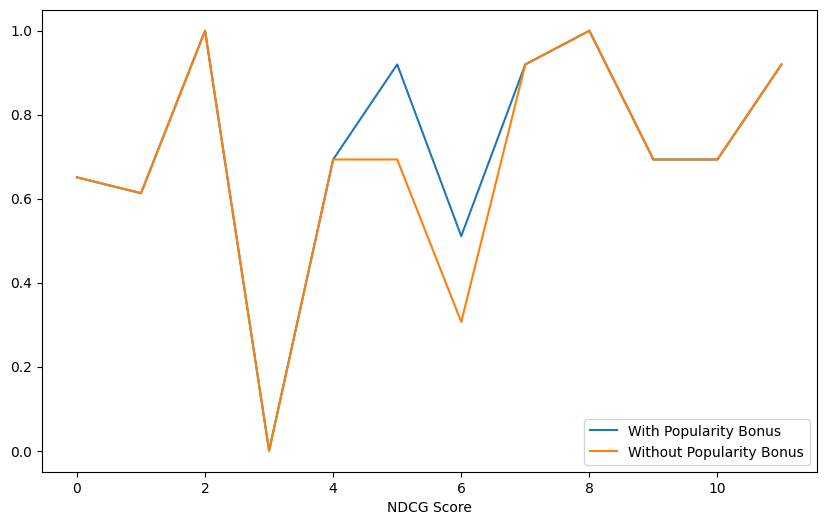

In [22]:
# plot NDCG scores
plt.figure(figsize=(10, 6))
plt.xlabel('NDCG Score')
# line plot
scores_with_bonus = [score[0] for score in ndcg_scores]
scores_without_bonus = [score[1] for score in ndcg_scores]
plt.plot(scores_with_bonus, label='With Popularity Bonus')
plt.plot(scores_without_bonus, label='Without Popularity Bonus')
plt.legend()


Starting alpha parameter analysis...

Testing alpha = 0.0
Mean NDCG: 0.789

Testing alpha = 0.1
Mean NDCG: 0.711

Testing alpha = 0.2
Mean NDCG: 0.718

Testing alpha = 0.3
Mean NDCG: 0.718

Testing alpha = 0.4
Mean NDCG: 0.718

Testing alpha = 0.5
Mean NDCG: 0.718

Testing alpha = 0.6
Mean NDCG: 0.718

Testing alpha = 0.7
Mean NDCG: 0.718

Testing alpha = 0.8
Mean NDCG: 0.718

Testing alpha = 0.9
Mean NDCG: 0.718

Testing alpha = 1.0
Mean NDCG: 0.269

Detailed Results:
----------------------------------------
Alpha: 0.0 - NDCG: 0.789
Alpha: 0.1 - NDCG: 0.711
Alpha: 0.2 - NDCG: 0.718
Alpha: 0.3 - NDCG: 0.718
Alpha: 0.4 - NDCG: 0.718
Alpha: 0.5 - NDCG: 0.718
Alpha: 0.6 - NDCG: 0.718
Alpha: 0.7 - NDCG: 0.718
Alpha: 0.8 - NDCG: 0.718
Alpha: 0.9 - NDCG: 0.718
Alpha: 1.0 - NDCG: 0.269

Best alpha: 0.0 (NDCG: 0.789)


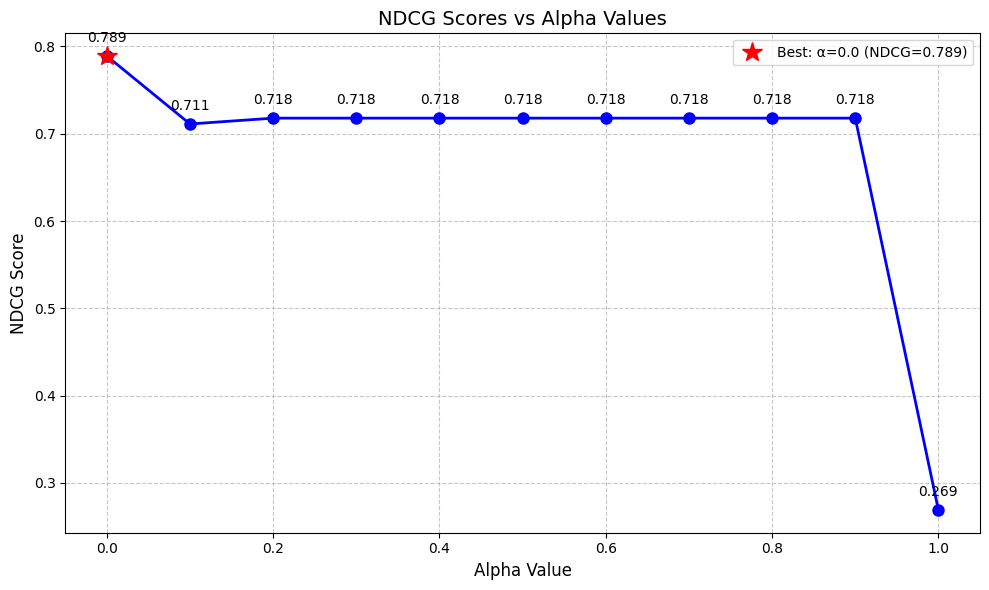

In [5]:
def test_alpha_values(recommender, train_df, books_data, matrices, profiles, test_df):
    """Test different alpha values and return their NDCG scores"""
    results = []
    
    # Test different alpha values
    for alpha in np.arange(0, 1.1, 0.1):
        alpha = round(alpha, 1)  # Round to avoid floating point issues
        print(f"\nTesting alpha = {alpha}")
        
        # Set the alpha value for recommendations
        recommendations = []
        ndcg_scores = []
        
        # Test for each user in test set
        test_users = test_df['user_id'].unique()
        for user_id in test_users[:100]:  # Limit to first 100 users for speed
            if user_id in train_df['user_id'].unique():
                # Get recommendations for this user with current alpha
                try:
                    user_recs = recommender.get_user_recommendations(
                        user_id,
                        train_df,
                        books_data,
                        matrices,
                        profiles,
                        alpha=alpha
                    )
                    
                    # Get test set books for this user
                    user_test = test_df[test_df['user_id'] == user_id]
                    test_books = set(user_test['book_id'])
                    
                    # Calculate NDCG
                    dcg = 0
                    for i, (book_id, _, _) in enumerate(user_recs):
                        if book_id in test_books:
                            dcg += 1 / np.log2(i + 2)
                    
                    idcg = sum(1 / np.log2(i + 2) for i in range(len(test_books)))
                    if idcg > 0:
                        ndcg = dcg / idcg
                        ndcg_scores.append(ndcg)
                
                except Exception as e:
                    print(f"Error processing user {user_id}: {str(e)}")
                    continue
        
        # Calculate mean NDCG for this alpha
        mean_ndcg = np.mean(ndcg_scores) if ndcg_scores else 0
        results.append({
            'alpha': alpha,
            'ndcg': mean_ndcg
        })
        print(f"Mean NDCG: {mean_ndcg:.3f}")
    
    return results

def plot_alpha_results(results):
    """Create visualization of alpha test results"""
    plt.figure(figsize=(10, 6))
    
    # Extract data
    alphas = [r['alpha'] for r in results]
    ndcgs = [r['ndcg'] for r in results]
    
    # Create line plot
    plt.plot(alphas, ndcgs, 'b-o', linewidth=2, markersize=8)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Customize plot
    plt.xlabel('Alpha Value', fontsize=12)
    plt.ylabel('NDCG Score', fontsize=12)
    plt.title('NDCG Scores vs Alpha Values', fontsize=14)
    
    # Add value annotations
    for alpha, ndcg in zip(alphas, ndcgs):
        plt.annotate(f'{ndcg:.3f}', 
                    (alpha, ndcg), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')
    
    # Find and mark best alpha
    best_idx = np.argmax(ndcgs)
    best_alpha = alphas[best_idx]
    best_ndcg = ndcgs[best_idx]
    plt.plot(best_alpha, best_ndcg, 'r*', markersize=15, label=f'Best: α={best_alpha} (NDCG={best_ndcg:.3f})')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the test and create visualization
def run_alpha_analysis(recommender, train_df, books_data, matrices, profiles, test_df):
    """Run complete alpha analysis with testing and visualization"""
    print("Starting alpha parameter analysis...")
    
    # Run tests
    results = test_alpha_values(recommender, train_df, books_data, matrices, profiles, test_df)
    
    # Print detailed results
    print("\nDetailed Results:")
    print("-" * 40)
    for result in results:
        print(f"Alpha: {result['alpha']:.1f} - NDCG: {result['ndcg']:.3f}")
    
    # Find best alpha
    best_result = max(results, key=lambda x: x['ndcg'])
    print(f"\nBest alpha: {best_result['alpha']} (NDCG: {best_result['ndcg']:.3f})")
    
    # Create visualization
    plot_alpha_results(results)
    
    return results

# Example usage:
# First load the system (you already have this code)
# recommender, train_df, books_data, matrices, profiles, test_df = load_system(n_samples=10000)

# Then run the analysis
results = run_alpha_analysis(recommender, train_df, books_data, matrices, profiles, test_df)